In [1]:
# Import the required packages

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
#import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools


In [2]:
#Set up plotting themes
sns.set_context('poster')
sns.set_style('darkgrid')

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [3]:
def clean_data(filename):
    # print(filename)
    # Handle errors. If there is an error, go to 'except' and return nothing.
    try:
        data = pd.read_csv('data/' + filename)

        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['blocks.thisRepN']).reset_index(drop=True)

        #If data file is incomplete, raise an error. 
        if sum(data['node idx'].notna()) < 1400:
            raise TypeError('Incomplete Data')


        #Rt is average rt of all keys pressed
        data['rt'] = [np.mean(ast.literal_eval(data['key_resp.rt'][i])) if data['accuracy'][i] else np.NaN for i in range(len(data))]
        
        #Transition type is cross cluster if goes from boundary to boundary
        data['transition_type'] = ['cross cluster' if (data['node type'] == 'boundary')[i] & (data['node type'].shift() == 'boundary')[i] else 'within cluster' for i in range(len(data))]

        #Label conditions based on participant number as was designed in the experiment
        if data['participant'][0]%3 == 0:
            data['condition'] = 'random'
        elif data['participant'][0]%3 == 1:
            data['condition'] = 'music random'
        else:
            data['condition'] = 'structured'

        data['trial'] = np.arange(len(data))
        
        
    except:
        return None

    #Count the number of keys to be pressed for each stimuli
    data['num_keypress'] = [len(ast.literal_eval(data['stim'][i])) for i in range(len(data))]
    
    #Return the dataframe with relevant columns
    return data[['participant', 'trial', 'blocks.thisRepN', 'accuracy', 'condition', 'node type', 'transition_type', 'rt', 'stim', 'num_keypress']]


# Read the data files

In [4]:
#reads in all the NAMES of the data files from the 'data' folder. 
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('240') & f.endswith('csv')):
        data_files.append(f)

# Sanity Check 1 
Print out the data_files variable and test if correct files are being loaded

In [5]:
data_files

['240000_eb_music_2024-03-13_13h32.51.559.csv',
 '240001_eb_music_2024-03-13_13h28.21.687.csv',
 '240003_eb_music_2024-03-14_12h29.04.605.csv',
 '240004_eb_music_2024-03-14_12h59.27.819.csv',
 '240005_eb_music_2010-09-20_02h29.21.924.csv',
 '240006_eb_music_2010-09-21_01h01.38.600.csv',
 '240007_eb_music_2024-03-15_11h40.37.731.csv',
 '240008_eb_music_2024-03-15_12h02.14.101.csv',
 '240009_eb_music_2024-03-15_12h47.17.042.csv',
 '240010_eb_music_2010-09-21_02h04.06.427.csv',
 '240011_eb_music_2010-10-01_01h53.02.852.csv',
 '240012_eb_music_2024-03-25_12h29.30.924.csv',
 '240013_eb_music_2024-03-25_12h49.02.447.csv',
 '240014_eb_music_2010-10-01_02h46.04.024.csv',
 '240015_eb_music_2024-03-27_11h23.41.504.csv',
 '240016_eb_music_2010-10-03_00h47.33.136.csv',
 '240017_eb_music_2024-03-27_12h53.21.987.csv',
 '240018_eb_music_2024-03-27_13h18.21.516.csv',
 '240019_eb_music_2010-10-04_01h39.43.870.csv',
 '240020_eb_music_2024-03-28_12h16.20.572.csv',
 '240021_eb_music_2024-03-28_12h37.06.19

# Cleaning the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [13]:
df_clean = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)
# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'blocks.thisRepN', 'condition', 'node type', 'transition_type']).median(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

# Sanity Check 2
Print out the dataframe df_clearn_rt_outlier to see if it looks as expected. 

Take a note of the relevant columns

In [9]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,condition,node type,transition_type,rt,stim,num_keypress,node_transition_type
0,240000.0,0,0.0,1.0,random,non boundary,within cluster,1.471844,"('j',)",1,non boundary_within cluster
1,240000.0,1,0.0,1.0,random,non boundary,within cluster,0.459337,"('j',)",1,non boundary_within cluster
2,240000.0,2,0.0,1.0,random,boundary,within cluster,0.423757,"('l',)",1,boundary_within cluster
3,240000.0,3,0.0,1.0,random,non boundary,within cluster,0.669688,"('j', 'space')",2,non boundary_within cluster
4,240000.0,4,0.0,1.0,random,non boundary,within cluster,1.228632,"('j', 'l')",2,non boundary_within cluster
...,...,...,...,...,...,...,...,...,...,...,...
40595,240029.0,1395,6.0,1.0,structured,non boundary,within cluster,0.568107,"('j',)",1,non boundary_within cluster
40596,240029.0,1396,6.0,1.0,structured,boundary,within cluster,1.052871,"('j', 'space')",2,boundary_within cluster
40597,240029.0,1397,6.0,1.0,structured,non boundary,within cluster,1.178918,"('h',)",1,non boundary_within cluster
40598,240029.0,1398,6.0,1.0,structured,boundary,within cluster,0.719465,"('j', 'space')",2,boundary_within cluster


In [14]:
df_clean_rt_outlier['node_transition_type']=df_clean_rt_outlier['node type']+'_'+df_clean_rt_outlier['transition_type']
df_clean_participant['node_transition_type']=df_clean_participant['node type']+'_'+df_clean_participant['transition_type']


In [15]:
df_clean_participant

,participant,blocks.thisRepN,condition,node type,transition_type,trial,accuracy,rt,num_keypress,node_transition_type
0,240000.0,0.0,random,boundary,cross cluster,81.0,1.0,0.537916,2.0,boundary_cross cluster
1,240000.0,0.0,random,boundary,within cluster,98.0,1.0,0.549622,2.0,boundary_within cluster
2,240000.0,0.0,random,non boundary,within cluster,96.0,1.0,0.566307,2.0,non boundary_within cluster
3,240000.0,1.0,random,boundary,cross cluster,281.0,1.0,0.532537,2.0,boundary_cross cluster
4,240000.0,1.0,random,boundary,within cluster,303.0,1.0,0.536355,2.0,boundary_within cluster
...,...,...,...,...,...,...,...,...,...,...
604,240029.0,5.0,structured,boundary,within cluster,1109.0,1.0,0.659062,2.0,boundary_within cluster
605,240029.0,5.0,structured,non boundary,within cluster,1096.5,1.0,0.729545,2.0,non boundary_within cluster
606,240029.0,6.0,structured,boundary,cross cluster,1283.0,1.0,0.703492,2.0,boundary_cross cluster
607,240029.0,6.0,structured,boundary,within cluster,1298.0,1.0,0.699792,2.0,boundary_within cluster


# Plot RTs
The dataframe that is created above (df_clearn_rt_outlier) removes outliers where people may have responded too quickly or too slowly. This is the dataframe we want to work with. Let's start by plotting first. 

Plot a graph using python's seaborn package such that: 
1. The Y axis is the average response time
2. The X axis is the block number
3. The graph has three 'column' panels corresponding to the three conditions.


(Hint: Use the seaborn catplot function)

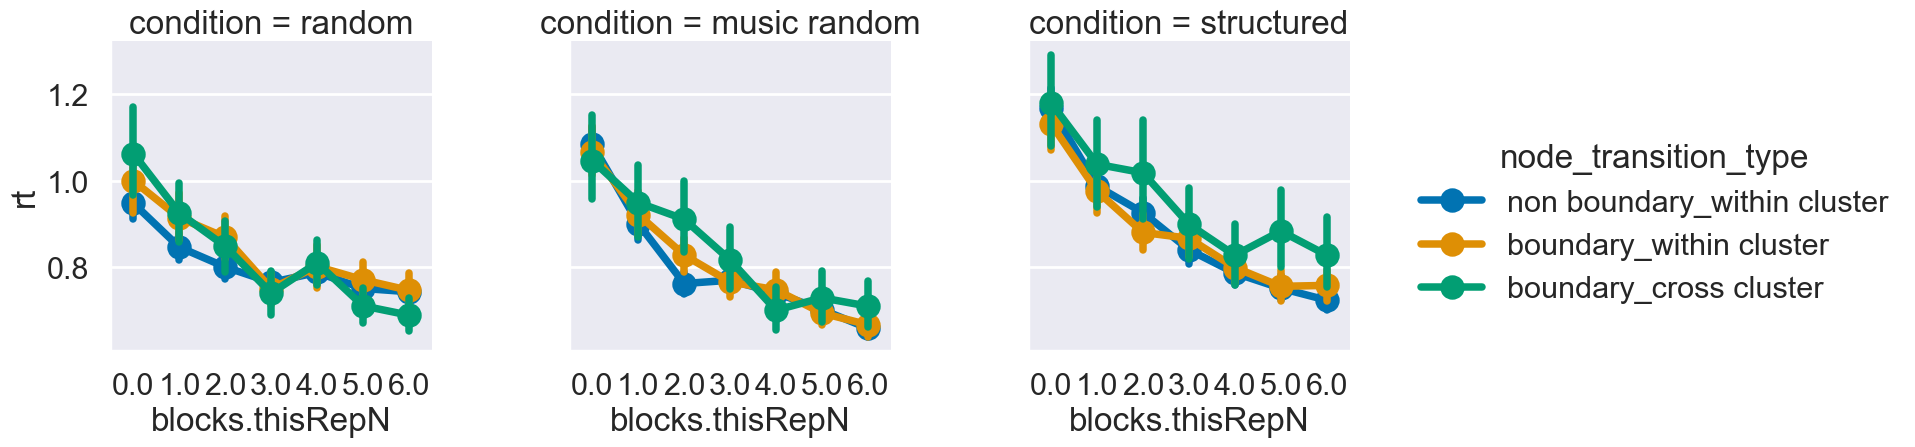

In [18]:
sns.catplot(data=df_clean_rt_outlier, y='rt', x='blocks.thisRepN', hue='node_transition_type', row=None, col='condition', 
            kind='point', margin_titles=True, estimator='mean', seed=0,
           palette=sns.color_palette("colorblind"))


# Plot Accuracies
That dataframe also has a column called 'accuracy'. Use that colum to plot a graph using python's seaborn package such that: 
1. The Y axis is the average accuracy
2. The X axis is the block number
3. The graph has three 'column' panels corresponding to the three conditions. 

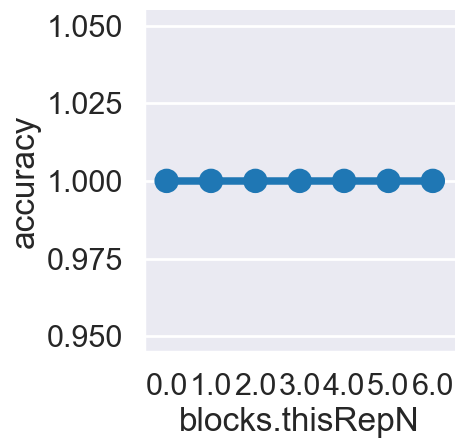

In [10]:
sns.catplot(data=df_clean_rt_outlier, y='accuracy', x='blocks.thisRepN', hue=None, row=None, col=None, kind='point', estimator='mean', seed=0, order=None, hue_order=None, row_order=None, col_order=None, col_wrap=None)





In [4]:
import seaborn as sns 
  
music = sns.load_dataset("data_files") 
g = sns.catplot(x="blocks.thisRepN", y=mean("accuracy"), 
                hue="condition", 
                data=music)

ValueError: 'data_files' is not one of the example datasets.